In [2]:
import os
import anndata
import logging
import numpy as np
import pandas as pd
from datetime import timedelta, datetime
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import leidenalg
import csv
from pandas import Timestamp
import re
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from scipy.stats import rankdata 
import scipy
import harmonypy as hm

In [3]:
sc.settings.verbosity =3
sc.logging.print_version_and_date()
sc.settings.set_figure_params(dpi=140, color_map='RdBu_r')

Running Scanpy 1.5.1, on 2021-04-23 10:05.


In [4]:
random_state=10
date="20210302"
path_to_fast="/fast/AG_Huebner/"
path_out=path_to_fast+ "huebner3/ANALYSES/20190926_gp_BadOyenhausen/scanpy/20200921/global_all"

# Functions

In [6]:
def filter_by_expression(adata_obj, DE_column, key='rank_genes_groups'):
#adata_obj=fbs_new_harmony.copy()
#key='rank_genes_groups'
#DE_column='leiden'
    def to_tensor(dataframe, columns = [], dtypes = {}, index = False):
        to_records_kwargs = {'index': index}
        if not columns:  # Default to all `dataframe.columns`
            columns = dataframe.columns
        if dtypes:       # Pull in modifications only for dtypes listed in `columns`
            to_records_kwargs['column_dtypes'] = {}
            for column in dtypes.keys():
                if column in columns:
                    to_records_kwargs['column_dtypes'].update({column: dtypes.get(column)})
        return dataframe[columns].to_records(**to_records_kwargs)
    
    gene_names = pd.DataFrame(adata_obj.uns[key]['names'])
    fraction_in_cluster_matrix = pd.DataFrame(
                np.zeros(gene_names.shape),
                columns=gene_names.columns,
                index=gene_names.index,
            )
    fraction_notin_cluster_matrix = pd.DataFrame(
                np.zeros(gene_names.shape),
                columns=gene_names.columns,
                index=gene_names.index,
            )
    in_cluster_expr_matrix = pd.DataFrame(
                np.zeros(gene_names.shape),
                columns=gene_names.columns,
                index=gene_names.index,
            )
    notin_cluster_matrix = pd.DataFrame(
                np.zeros(gene_names.shape),
                columns=gene_names.columns,
                index=gene_names.index,
            )
    allin_cluster_expr_matrix = pd.DataFrame(
                np.zeros(gene_names.shape),
                columns=gene_names.columns,
                index=gene_names.index,
            )
    allnotin_cluster_matrix = pd.DataFrame(
                np.zeros(gene_names.shape),
                columns=gene_names.columns,
                index=gene_names.index,
            )

    for cluster_number in fraction_in_cluster_matrix.columns:
        dummy=adata_obj.raw[:, adata_obj.uns['rank_genes_groups']['names'][cluster_number].tolist()]
        dummy.obs=adata_obj.obs
        subset_cluster=dummy[dummy.obs[DE_column].isin([cluster_number])]
        subset_notin_cluster=dummy[np.logical_not(dummy.obs[DE_column].isin([cluster_number]))]
    
        # Percent of cluster expressing
        if subset_cluster.shape[0] != 0:
            total_incluster=subset_cluster.shape[0]
        else: 
            total_incluster=np.nan

        if subset_notin_cluster.shape[0] != 0:
            total_outcluster=subset_notin_cluster.shape[0]
        else: 
            total_outcluster=np.nan
        
        fraction_in_cluster_matrix[cluster_number]=[(subset_cluster.X[:,gene_toanalyze].count_nonzero()/total_incluster) for gene_toanalyze in fraction_in_cluster_matrix.index]
        fraction_notin_cluster_matrix[cluster_number]=[(subset_notin_cluster.X[:,gene_toanalyze].count_nonzero()/total_outcluster) for gene_toanalyze in fraction_notin_cluster_matrix.index]

        #fraction_in_cluster_matrix[cluster_number]=[(subset_cluster.X[:,gene_toanalyze].count_nonzero()/subset_cluster.shape[0]) for gene_toanalyze in fraction_in_cluster_matrix.index]
        #fraction_notin_cluster_matrix[cluster_number]=[(subset_notin_cluster.X[:,gene_toanalyze].count_nonzero()/subset_notin_cluster.shape[0]) for gene_toanalyze in fraction_notin_cluster_matrix.index]
        
        # Expression level (only by expressed)
        in_cluster_expr_matrix[cluster_number]=[(subset_cluster.X[:,gene_toanalyze][subset_cluster.X[:,gene_toanalyze].nonzero()].mean()) for gene_toanalyze in in_cluster_expr_matrix.index]
        notin_cluster_matrix[cluster_number]=[(subset_notin_cluster.X[:,gene_toanalyze][subset_notin_cluster.X[:,gene_toanalyze].nonzero()].mean()) for gene_toanalyze in notin_cluster_matrix.index]
    
        # Expression_all in cluster
        allin_cluster_expr_matrix[cluster_number]=[(subset_cluster.X[:,gene_toanalyze].mean()) for gene_toanalyze in allin_cluster_expr_matrix.index]
        allnotin_cluster_matrix[cluster_number]=[(subset_notin_cluster.X[:,gene_toanalyze].mean()) for gene_toanalyze in allnotin_cluster_matrix.index]

    # Generate the last table results
    result = adata_obj.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    result['pi'] = to_tensor(fraction_in_cluster_matrix)
    result['po'] = to_tensor(fraction_notin_cluster_matrix)
    result['ei'] = to_tensor(allin_cluster_expr_matrix)
    result['eo'] = to_tensor(allnotin_cluster_matrix)
    
    results =pd.DataFrame(
        {group + '_' + key[:2]: result[key][group]
        for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges', 'pi', 'po', "ei", "eo"]})

    return results

In [7]:
def multivariateGrid(col_x, col_y, col_k, df, k_is_color=False, scatter_alpha=.5, scatter_size=4):
    def colored_scatter(x, y, c=None, scatter_size=scatter_size):
        def scatter(*args, **kwargs):
            args = (x, y)
            if c is not None:
                kwargs['c'] = c
            kwargs['alpha'] = scatter_alpha
            plt.scatter(*args, **kwargs, s=scatter_size)

        return scatter

    g = sns.JointGrid(
        x=col_x,
        y=col_y,
        data=df
    )
    color = None
    legends=[]
    for name, df_group in df.groupby(col_k):
        legends.append(name)
        if k_is_color:
            color=name
        g.plot_joint(
            colored_scatter(df_group[col_x],df_group[col_y],color),
        )
        sns.distplot(
            df_group[col_x].values,
            ax=g.ax_marg_x,
            color=color
        )
        sns.distplot(
            df_group[col_y].values,
            ax=g.ax_marg_y,
            color=color,            
            vertical=True
        )
    # Do also global Hist:
    #sns.distplot(
    #    df[col_x].values,
    #    ax=g.ax_marg_x,
    #    color='grey'
    #)
    #sns.distplot(
    #    df[col_y].values.ravel(),
    #    ax=g.ax_marg_y,
    #    color='grey',
    #    vertical=True
    #)
    plt.legend(legends)

In [8]:
def stacked_barplot(adata, xaxis, stack, xaxis_label, legend_label, shift_top=0.2, xaxis_rotation=45, figsize=(10,10), percent=True):
    tmp=pd.crosstab(adata.obs[xaxis],
                adata.obs[stack]).sum(axis=1)
    
    ax= pd.crosstab(adata.obs[xaxis], 
                    adata.obs[stack]).apply(lambda r: r/r.sum()*100, axis=1)
    #ax_1 = ax.plot.bar(figsize=(10,10),stacked=True, rot=0, colors=colors)
    ax_1 = ax.plot.bar(figsize=figsize,stacked=True, rot=0)
    #display(ax)
    #plt.legend(title="Subject") # loc='upper center', bbox_to_anchor=(0.1, 1.0), 
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title=legend_label)
    plt.xlabel(xaxis_label,fontweight="bold")
    plt.ylabel('Percent Distribution',fontweight="bold")
    
    if percent:
        for rec in ax_1.patches:
            height = rec.get_height()
            ax_1.text(rec.get_x() + rec.get_width() / 2, rec.get_y() + height/2, "{:.0f}%".format(height),
                   ha = 'center', va='center', fontsize=14.5, weight='bold') #
    
    for xaxistick in range(ax.shape[0]):
        ax_1.text(xaxistick-shift_top,110,tmp[xaxistick],va='center', rotation=45, fontsize=14.5, weight='bold')
    
    plt.xticks(rotation=xaxis_rotation)
    
    ax_1.grid(False)
    plt.show()

In [9]:
def makevector_topmarkers(anndata, top_n, ldFC_cutoff=0.5, pvals_adj_cutoff=10**-30): 
    results=anndata.uns['rank_genes_groups']
    clusters = results['names'].dtype.names
    top_genes=[]
    for cluster in clusters:
        topgenes_cluster=results['names'][cluster][np.where((results['logfoldchanges'][cluster]>=ldFC_cutoff) & (results['pvals_adj'][cluster]<(pvals_adj_cutoff)))][0:top_n]
        top_genes.extend(topgenes_cluster)
    return(top_genes)

In [10]:
def append_solo(adata):
    d2 = pd.DataFrame()
    for f in set(adata.obs['Sample']):
        if os.path.exists("/fast/AG_Huebner/huebner3/ANALYSES/20190926_gp_BadOyenhausen/scanpy/Global_touse/individual_h5ads_20200430/" + f + "/solo_out/softmax_scores.npy"):
            solo1 = np.load("/fast/AG_Huebner/huebner3/ANALYSES/20190926_gp_BadOyenhausen/scanpy/Global_touse/individual_h5ads_20200430/" + f + "/solo_out/softmax_scores.npy")
            solo2 = np.load("/fast/AG_Huebner/huebner3/ANALYSES/20190926_gp_BadOyenhausen/scanpy/Global_touse/individual_h5ads_20200430/" + f + "/solo_out/is_doublet.npy")
            h5ad = sc.read_h5ad("/fast/AG_Huebner/huebner3/ANALYSES/20190926_gp_BadOyenhausen/scanpy/Global_touse/individual_h5ads_20200430/" + f + "/" + f + ".h5ad")
            d = pd.DataFrame({'barcode': h5ad.obs.index, 'solo_score': solo1, 'predicted_doublets_solo': solo2})
            d2 = pd.concat([d2,d], axis=0)
    d2.index = d2['barcode']
    d2 = d2[['solo_score','predicted_doublets_solo']]
    adata_solo = adata[adata.obs.index.isin(d2.index)]
    tmp=adata_solo.obs
    tmp=tmp.merge(d2, how='inner', left_index = True, right_index = True)
    adata_solo.obs['solo_score'] = tmp['solo_score']
    adata_solo.obs['predicted_doublets_solo'] = tmp['predicted_doublets_solo']   
    return(adata_solo)

In [11]:
def densityplot(xdat, ydat, xlab, ylab):
    #data definition
    #xdat = data[xdat]
    #ydat = data[ydat]
    
    #histogram definition
    xyrange = [[min(xdat),max(xdat)],[min(ydat),max(ydat)]] # data range
    bins = [100,100] # number of bins
    thresh = 3  #density threshold

    # histogram the data
    hh, locx, locy = scipy.histogram2d(xdat, ydat, range=xyrange, bins=bins)
    posx = np.digitize(xdat, locx)
    posy = np.digitize(ydat, locy)

    #select points within the histogram
    ind = (posx > 0) & (posx <= bins[0]) & (posy > 0) & (posy <= bins[1])
    hhsub = hh[posx[ind] - 1, posy[ind] - 1] # values of the histogram where the points are
    xdat1 = xdat[ind][hhsub < thresh] # low density points
    ydat1 = ydat[ind][hhsub < thresh]
    hh[hh < thresh] = np.nan # fill the areas with low density by NaNs
    
    
    plt.imshow(np.flipud(hh.T),cmap='jet',extent=np.array(xyrange).flatten(), interpolation='none', origin='upper', aspect='auto')
    #plt.colorbar()   
    plt.plot(xdat1, ydat1, '.',color='darkblue')
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.show()

In [12]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 

In [13]:
def correlation_analysis(scanpy_object, column_tosplitby, sum_or_mean):
    d = {}
    for cluster_number in np.unique(scanpy_object.obs[column_tosplitby].values):
        #cluster_number=np.unique(heart.obs['louvain_annotated'].values)[1]
        scanpy_object_subset = scanpy_object[scanpy_object.obs[column_tosplitby].isin([cluster_number])]

        if sum_or_mean=="mean":
            d[cluster_number] = np.squeeze(np.asarray(scanpy_object_subset.raw.X.mean(axis=0))) #np.log(+1)
        elif sum_or_mean=="sum":
            d[cluster_number] = np.squeeze(np.asarray(scanpy_object_subset.raw.X.sum(axis=0))) #np.log(+1)
        del scanpy_object_subset
        
    return d

# Clustering of all samples

This merged object now contains all scores from scrublet, solo and clinical and sample metadata

In [125]:
all_samples=sc.read_h5ad(path_to_fast + "huebner3/ANALYSES/20190926_gp_BadOyenhausen/scanpy/" + date + "/Global_touse/Global_BOBSCBIC_all" + date + "_meta_touse.h5ad")

In [129]:
all_samples.obs['predicted_doublets_solo'].value_counts()

False    954887
True      63610
Name: predicted_doublets_solo, dtype: int64

In [130]:
all_samples.obs['predicted_doublets_log'].value_counts()

False    974115
True      44382
Name: predicted_doublets_log, dtype: int64

In [131]:
all_samples.obs['predicted_doublets_z'].value_counts()

False    994504
True      23993
Name: predicted_doublets_z, dtype: int64

In [132]:
all_samples.obs['predicted_doublets_default'].value_counts()

False    981892
True      36605
Name: predicted_doublets_default, dtype: int64

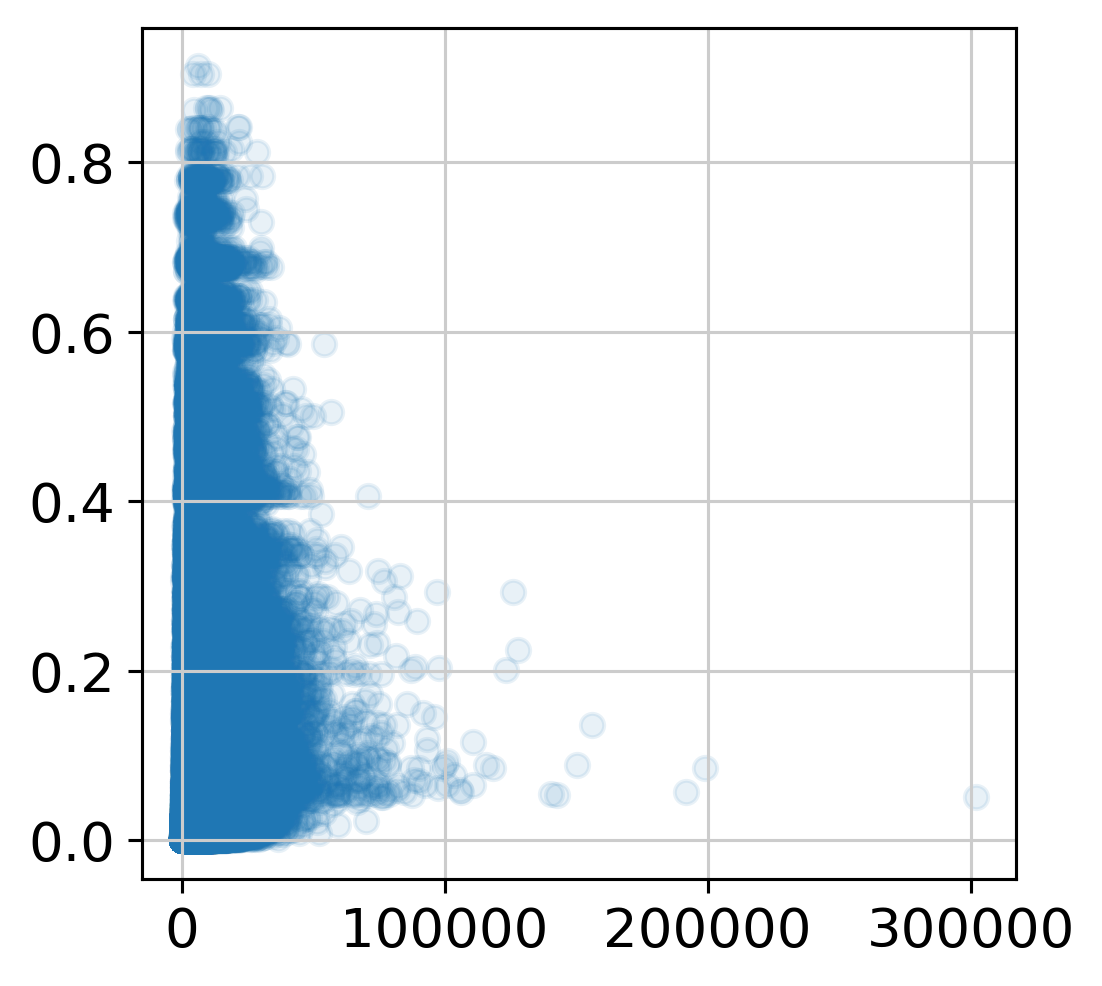

In [134]:
plt.scatter(all_samples.obs['n_counts'], 
            all_samples.obs['scrublet_score_log'], alpha=.1)

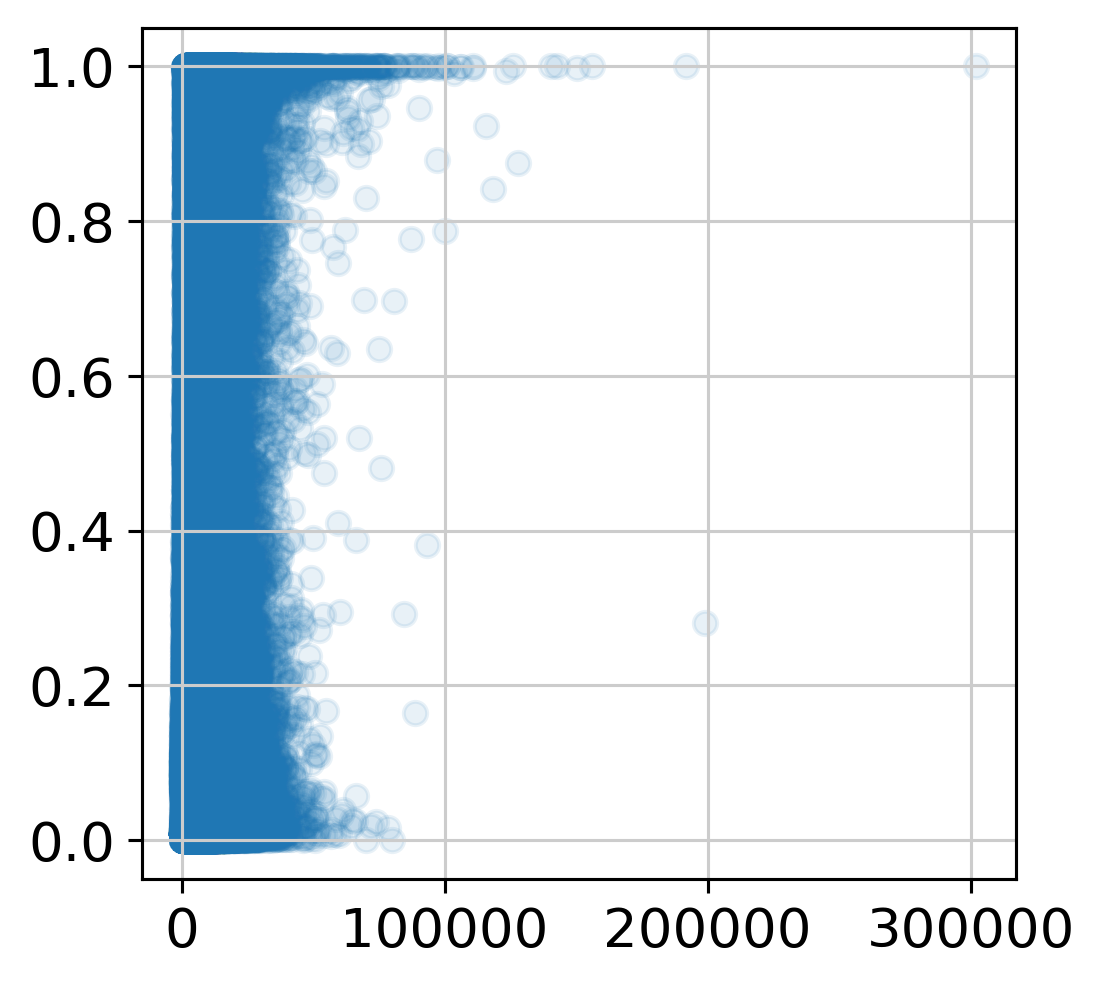

In [135]:
plt.scatter(all_samples.obs['n_counts'], 
            all_samples.obs['solo_score'], alpha=.1)

In [138]:
all_samples=all_samples[all_samples.obs['n_genes']<=5000, :].copy() # zuvor 8k
all_samples=all_samples[all_samples.obs['n_counts']<=15000, :].copy() # before: 20k
all_samples=all_samples[all_samples.obs['n_genes']>=300, :].copy()
all_samples=all_samples[all_samples.obs['n_counts']>=300, :].copy()
all_samples=all_samples[all_samples.obs['percent_mito']<=0.01, :].copy() # before: 0.01
all_samples=all_samples[all_samples.obs['percent_ribo']<=0.01, :].copy() # before: 0.01
all_samples=all_samples[~all_samples.obs['predicted_doublets_solo']]

# Clustering

In [12]:
all_samples=sc.read_h5ad(path_to_fast + "huebner3/ANALYSES/20190926_gp_BadOyenhausen/scanpy/" + date + "/Global_touse/global_all_FILTERED.h5ad")

In [13]:
sc.pp.normalize_per_cell(all_samples, counts_per_cell_after=1e4)
sc.pp.log1p(all_samples)
all_samples.raw=all_samples

normalizing by total count per cell
    finished (0:00:15): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [ ]:
sc.pp.highly_variable_genes(all_samples)
all_samples_hvg = all_samples[:, all_samples.var['highly_variable']]

sc.pp.regress_out(all_samples_hvg, ['n_counts', 'percent_mito'])
sc.pp.scale(all_samples_hvg, max_value = 10)
all_samples_hvg.shape

extracting highly variable genes
    finished (0:00:26)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use


In [ ]:
#all_samples_hvg.write(path_to_fast + "huebner3/ANALYSES/20190926_gp_BadOyenhausen/scanpy/20200921/Global_touse/global_all_HVG.h5ad")

In [ ]:
sc.tl.pca(all_samples_hvg, svd_solver = 'arpack', random_state = random_state)

In [ ]:
all_samples_harmony=all_samples_hvg.copy()

In [13]:
num_pcs= 40

In [110]:
del all_samples_hvg

In [111]:
pca = all_samples_harmony.obsm['X_pca']
batch = all_samples_harmony.obs['Patient']
meta_data = all_samples_harmony.obs

In [112]:
ho = hm.run_harmony(pca, meta_data, ['Patient'], random_state=random_state, epsilon_harmony = -float('Inf')) 

2020-06-02 23:25:15,962 - harmonypy - INFO - Iteration 1 of 10
2020-06-02 23:25:47,041 - harmonypy - INFO - Iteration 2 of 10
2020-06-02 23:26:16,364 - harmonypy - INFO - Iteration 3 of 10
2020-06-02 23:26:49,193 - harmonypy - INFO - Iteration 4 of 10
2020-06-02 23:27:18,434 - harmonypy - INFO - Iteration 5 of 10
2020-06-02 23:27:48,670 - harmonypy - INFO - Iteration 6 of 10
2020-06-02 23:28:18,595 - harmonypy - INFO - Iteration 7 of 10
2020-06-02 23:28:48,654 - harmonypy - INFO - Iteration 8 of 10
2020-06-02 23:29:16,442 - harmonypy - INFO - Iteration 9 of 10
2020-06-02 23:29:46,313 - harmonypy - INFO - Iteration 10 of 10
2020-06-02 23:30:05,960 - harmonypy - INFO - Stopped before convergence


In [113]:
res = pd.DataFrame(ho.Z_corr)
res=res.T
all_samples_harmony.obsm['X_pca'] = res.values

In [114]:
#all_samples_harmony.write(path_to_fast + "huebner3/ANALYSES/20190926_gp_BadOyenhausen/scanpy/20200921/Global_touse/lobal_all_HARMONY.h5ad")

In [12]:
#all_samples_harmony=sc.read_h5ad(path_to_fast + "huebner3/ANALYSES/20190926_gp_BadOyenhausen/scanpy/20210302/Global_touse/global_all_HARMONY.h5ad")

In [ ]:
sc.pp.neighbors(all_samples_harmony, 
                n_pcs=num_pcs, 
                random_state=random_state, 
                n_neighbors= 50)

computing neighbors
    using 'X_pca' with n_pcs = 40


In [ ]:
sc.tl.umap(all_samples_harmony, random_state = random_state, min_dist = 0.01, spread = 3, n_components=2)

In [ ]:
#all_samples_harmony.write(path_to_fast + "huebner3/ANALYSES/20190926_gp_BadOyenhausen/scanpy/20200921/Global_touse/global_all_uMAP.h5ad")

In [13]:
#all_samples_harmony=sc.read_h5ad(path_to_fast + "huebner3/ANALYSES/20190926_gp_BadOyenhausen/scanpy/20210302/Global_touse/global_all_LEIDEN.h5ad")

In [ ]:
sc.tl.leiden(all_samples_harmony, resolution = 0.1, random_state = random_state, 
             key_added="leiden_01")
sc.tl.leiden(all_samples_harmony, resolution = 0.2, random_state = random_state, 
             key_added="leiden_02")
sc.tl.leiden(all_samples_harmony, resolution = 0.3, random_state = random_state, 
             key_added="leiden_03")
sc.tl.leiden(all_samples_harmony, resolution = 0.4, random_state = random_state,
             key_added="leiden_04")

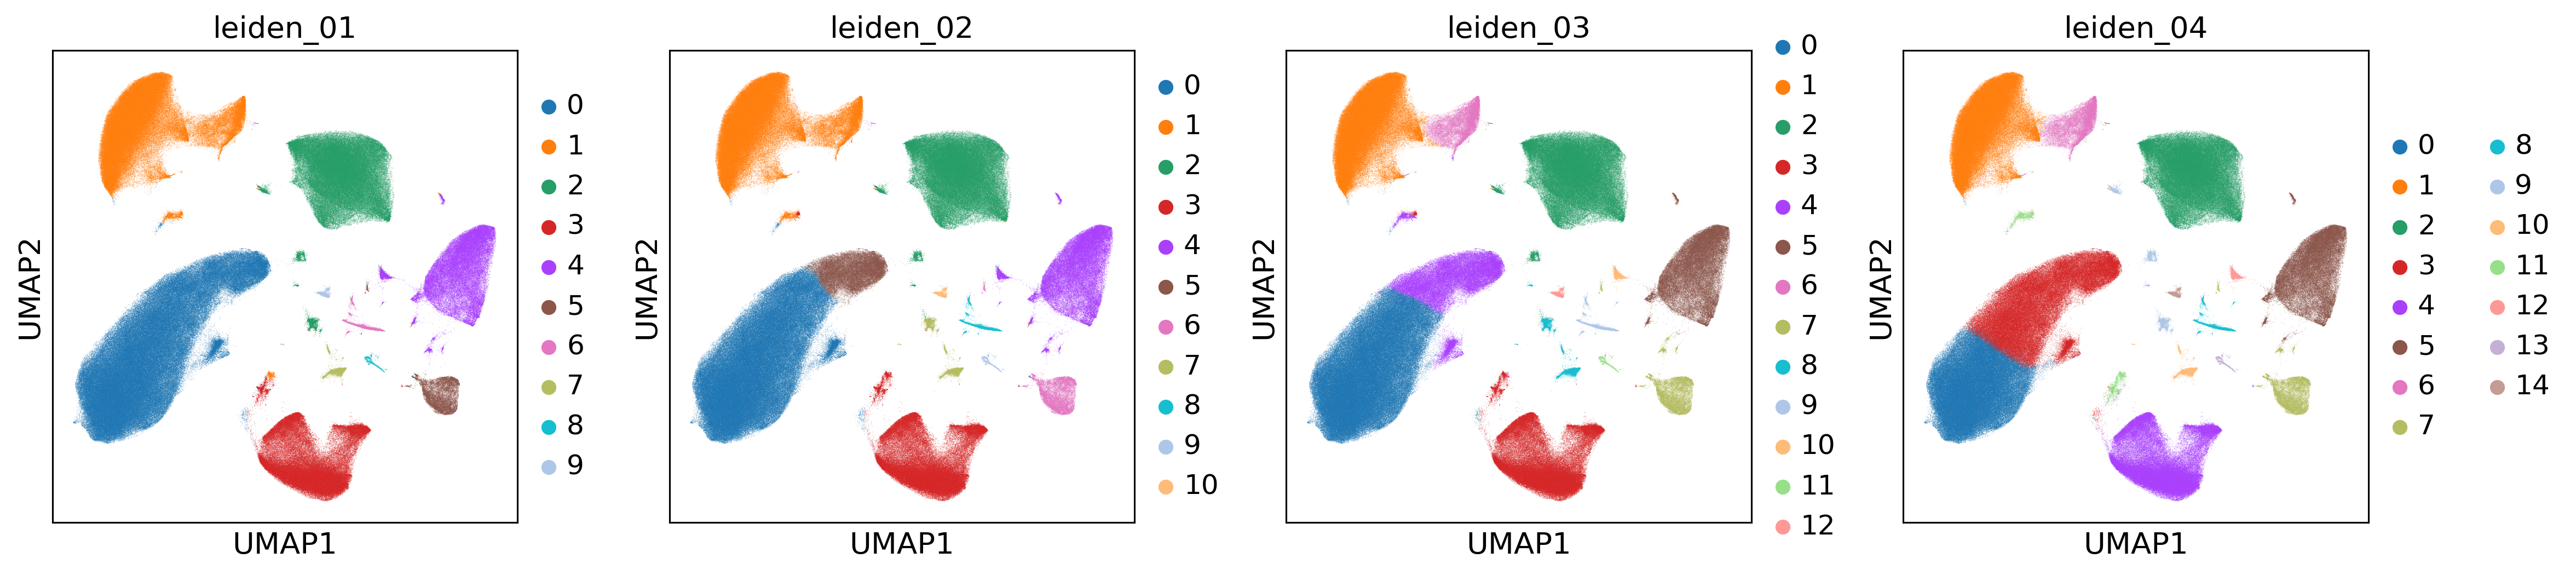

In [77]:
sc.pl.umap(all_samples_harmony,
           color=["leiden_01", 'leiden_02', 'leiden_03', 'leiden_04'])

In [97]:
# Backup
#global_all_RAW=sc.read_h5ad(path_to_fast + "huebner3/ANALYSES/20190926_gp_BadOyenhausen/scanpy/20210302/Global_touse/global_all_FILTERED_OLDSTATES.h5ad")
#global_all_RAW.obs=all_samples_harmony.obs
#global_all_RAW.write(path_to_fast + "huebner3/ANALYSES/20190926_gp_BadOyenhausen/scanpy/20210302/Global_touse/global_all_RAW_V1.h5ad")

Annotate cell types

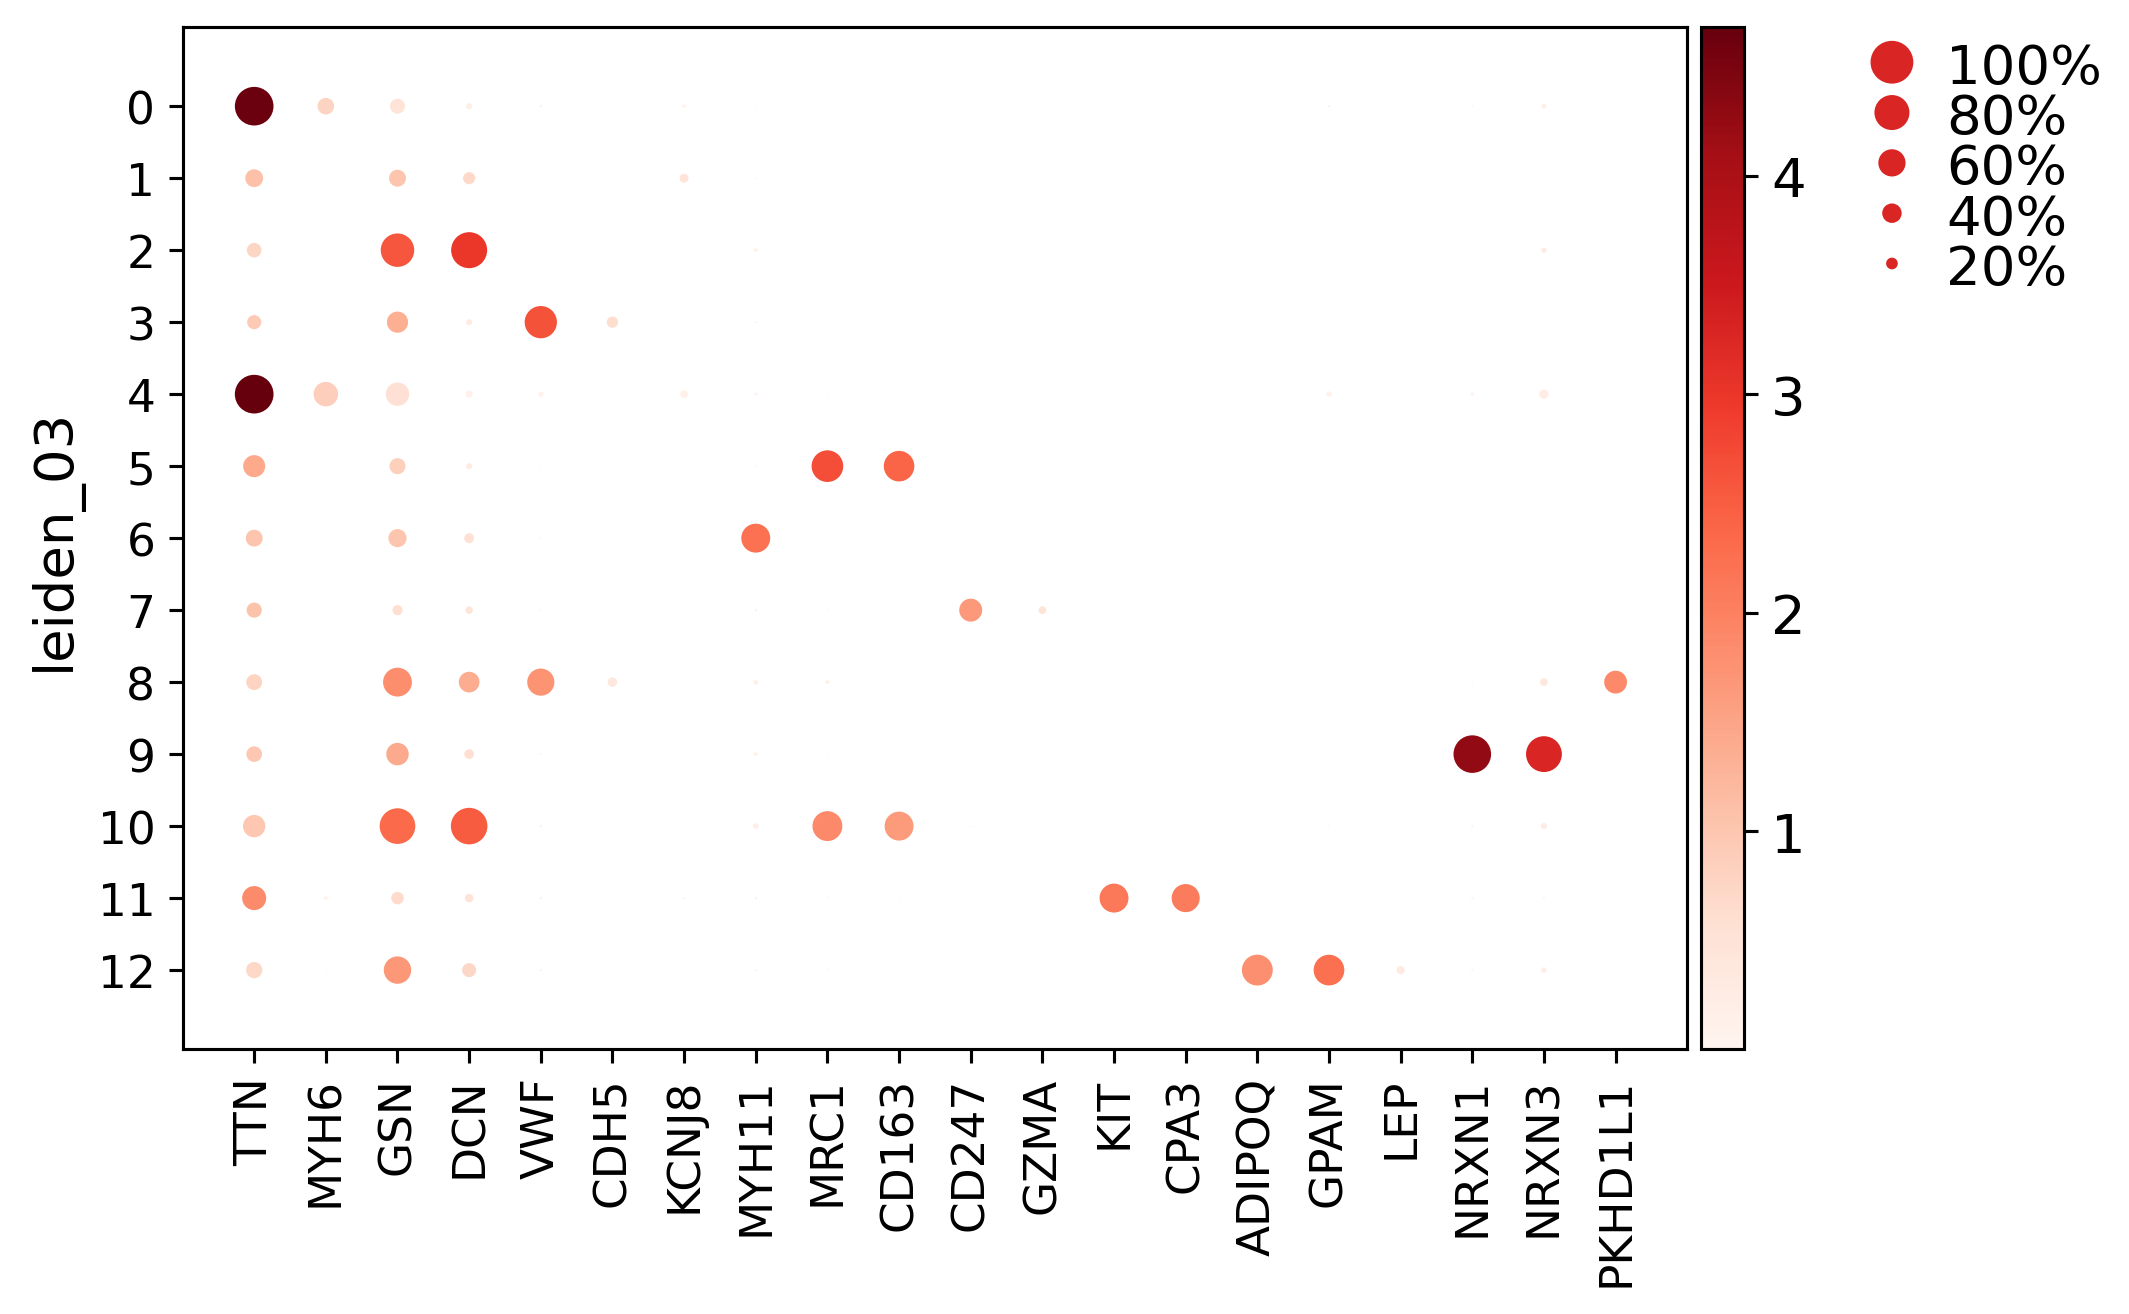

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[7.0, 0, 0.2, 0.5, 0.25])

In [100]:
sc.pl.dotplot(all_samples_harmony, ["TTN", "MYH6", 
                                         "GSN", "DCN", 
                                         "VWF", "CDH5", 
                                         "KCNJ8", "MYH11", 
                                         "MRC1", "CD163", 
                                         "CD247", "GZMA", 
                                          "KIT", "CPA3", 
                                         'ADIPOQ', "GPAM", "LEP",
                                         "NRXN1", "NRXN3",
                                      "PKHD1L1"], groupby='leiden_03')

In [37]:
all_samples_harmony.obs['cell_type']=all_samples_harmony.obs['leiden_03']
subs = {
    "0":"CM",
    "1":"PC", # 
    "2":"FB",
    "3":"vEC", # e.g. venous and arterial ECs
    "4":"CM",
    "5":"Myeloid",
    "6":"SMC", 
    "7":"Lymphoid",
    "8":"nonvEC", # lymphatic ECs, Endocardial cells
    "9":"N",
    "10":"FB", 
    "11":"Mast",
    "12":"AD"
     }
#rev_subs = { v:k for k,v in subs.items()}
x=[subs.get(item,item)  for item in all_samples_harmony.obs['cell_type']]
all_samples_harmony.obs['cell_type']=x
pd.value_counts(all_samples_harmony.obs['cell_type'])

CM          315618
FB          155714
PC          152504
vEC         116794
Myeloid      70036
SMC          22940
Lymphoid     20085
nonvEC       11058
N            10098
Mast          3459
AD            2775
Name: cell_type, dtype: int64

In [112]:
# Backup
#global_all_RAW=sc.read_h5ad(path_to_fast + "huebner3/ANALYSES/20190926_gp_BadOyenhausen/scanpy/20210302/Global_touse/global_all_FILTERED_OLDSTATES.h5ad")
#global_all_RAW.obs=all_samples_harmony.obs
#global_all_RAW.write(path_to_fast + "huebner3/ANALYSES/20190926_gp_BadOyenhausen/scanpy/20210302/Global_touse/global_all_RAW_V1.h5ad")

In [113]:
for i in np.unique(global_all_RAW.obs.cell_type):
    print("Save " + i)
    tmp=global_all_RAW[global_all_RAW.obs.cell_type.isin([i])].copy()
    tmp.write(path_to_fast + "huebner3/ANALYSES/20190926_gp_BadOyenhausen/scanpy/20210302/Global_touse/" + i + "_20210305_V1_RAW.h5ad")

Save AD
Save CM
Save FB
Save Lymphoid
Save Mast
Save Myeloid
Save N
Save PC
Save SMC
Save nonvEC
Save vEC


-> Please continue reading the subclustering scripts. The subclusterings were used to annotate unassigned (greyed out) states. This information was merged to .obs. The steps you can see below

# Grey out not-validated states

Side note: During subcluserting we identify states with chimeric profiles (see scripts from subclustering). Those states are termed "unassigned" and are removed from downstream analysis. 

In [ ]:
all_samples=sc.read_h5ad("/fast/AG_Huebner/huebner3/ANALYSES/20190926_gp_BadOyenhausen/scanpy/20210302/Global_touse/global_all_ANNOTATED_CELLSTATES_V8.h5ad")

In [ ]:
sc.pl.umap(all_samples_harmony,
           color=["cell_type"])

In [55]:
all_samples_harmony.obs['cell_type_new']=all_samples_harmony.obs['cell_type']

In [64]:
all_samples_harmony.obs.cell_type_new.cat.categories

Index(['AD', 'CM', 'FB', 'Lymphoid', 'Mast', 'Myeloid', 'N', 'PC', 'SMC',
       'nonvEC', 'vEC'],
      dtype='object')

In [66]:
categories = np.array(
     ['AD', 'CM', 'FB', 'Lymphoid', 'Mast', 'Myeloid', 'N', 'PC', 'SMC',
       'nonvEC', 'vEC', 'NotVal'])
all_samples_harmony.obs.cell_type_new = pd.Categorical(
   all_samples_harmony.obs.cell_type_new, categories=categories, ordered=True)

In [67]:
all_togreyout=np.where(~all_samples_harmony.obs.unassigned.isin(['TRUE']))[0]
all_samples_harmony.obs.cell_type_new[all_togreyout]="unassigned"
#all_samples_harmony.obs.cell_type

In [76]:
all_samples_harmony.uns['cell_type_new_colors'][11]="#CCCCCC"

In [58]:
subs = {
    "SMC":"Mural",
    "PC":"Mural",
    "nonvEC":"EC",
    "vEC":"EC",
     }
#rev_subs = { v:k for k,v in subs.items()}
x=[subs.get(item,item)  for item in global_all_RAW.obs['cell_type_toplot2']]
global_all_RAW.obs['cell_type_toplot2']=x
pd.value_counts(global_all_RAW.obs['cell_type_toplot2'])

CM               310978
Mural            170281
FB               142816
EC               115548
Myeloid           59217
not validated     51008
Lymphoid          16878
N                  9666
AD                 2576
Mast               2113
Name: cell_type_toplot2, dtype: int64

In [67]:
global_all_RAW.uns['cell_type_toplot2_colors'][9]="#CCCCCC"

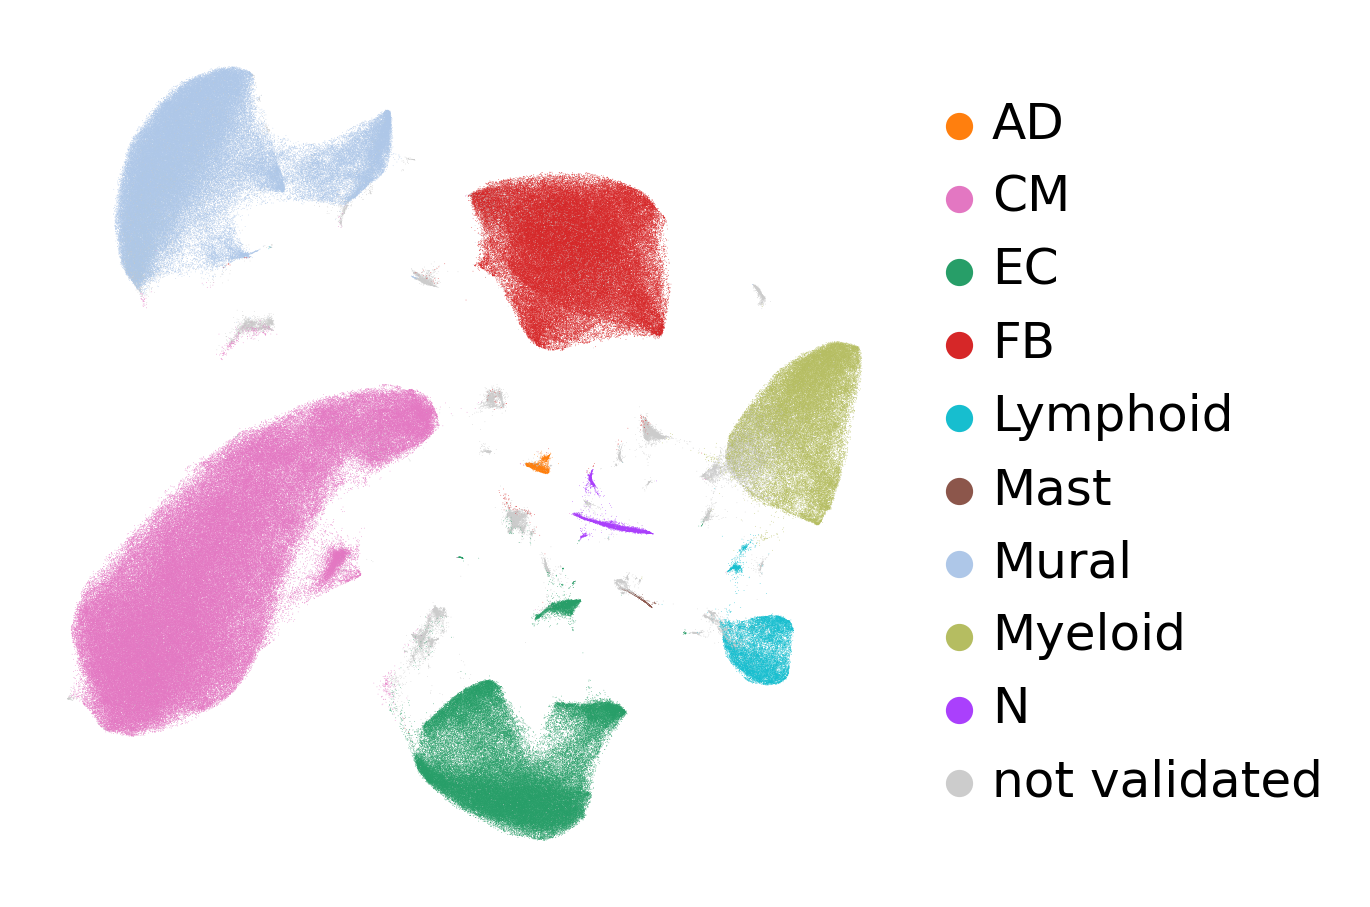

In [72]:
sc.pl.umap(global_all_RAW,
           color=['cell_type_toplot2'],
          frameon=False, title="")